<a href="https://colab.research.google.com/github/Nannanpeng/Econ_Dynamic_Programming/blob/master/Optimal_growth_model_I_with_numba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade quantecon
!pip install interpolation

Requirement already up-to-date: quantecon in /usr/local/lib/python3.6/dist-packages (0.4.8)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from interpolation import interp
from numba import jit, njit, jitclass, prange, float64, int32
from quantecon.optimize.scalar_maximization import brent_max
import time
%matplotlib inline

In [3]:
ogm_data=[('alpha', float64),
     ('beta', float64),
     ('y_grids', float64[:]),
     ('mc_shocks', float64[:]),
     ('gamma', float64),
     ('mu', float64),
     ('s', float64)
    ]

@jitclass(ogm_data)
class OptimalGrowthModel:
  def __init__(self, alpha=0.4,
             beta=0.96,       
             mu=0,          # shock location parameter
             s=0.1,        # shock scale parameter
             gamma=1.5,
             grid_max=4,
             grid_size=120,
             shock_size=250,
             seed=1234):
    
    self.alpha, self.beta = alpha, beta
    self.y_grids = np.linspace(1e-4, grid_max, grid_size)
    self.mu, self.s = mu, s
    np.random.seed(seed)
    self.mc_shocks = np.exp(mu + s*np.random.randn(shock_size))
    self.gamma = gamma

  def u(self, c):
    gamma = self.gamma
    return np.log(c) if gamma == 1 else c**(1-gamma)/(1-gamma) 
  
  def f(self, k):
    return k**self.alpha
  

@njit
def state_action_value(c, y, v, ogm):
  u, f, beta, y_grids, z = ogm.u, ogm.f, ogm.beta, ogm.y_grids, ogm.mc_shocks
  fun_v = lambda x: interp(y_grids, v, x)
  value = u(c) + beta * fun_v(f(y-c)*z).mean()
  return value

@njit
def find_best_c(y, v, ogm):
  maximizer, maximum, _ = brent_max(state_action_value, 0, y, args=(y, v, ogm))
  return maximizer, maximum

@njit(parallel=True)
def T(v, ogm):
  Tv = np.empty_like(v)
  for i in prange(len(ogm.y_grids)):
    val = ogm.y_grids[i]
    Tv[i] = find_best_c(val, v, ogm)[1]
  return Tv


def compute_value_function(ogm, max_iter=500, tol=1e-5, verbose=True):
  v = np.ones_like(ogm.y_grids)
  i = 0
  err = 1 + tol
  start_t = time.time()
  while i < max_iter and err > tol:
    Tv = T(v, ogm)
    i += 1
    err = np.max(np.abs(Tv - v))
    v = Tv
    if verbose and i%25==0:
      print(f'Error is {err} at interation {i}.')
    
    if i == 20:
      tol_t = time.time() - start_t
      print(f'20 iterations take {tol_t:.3f}.\n')

  if i == max_iter:
    raise ValueError('Iteration failed.')
  
  if verbose:
    print(f'\nConverged on interation {i}!')

  return v
  
@njit(parallel=True)
def compute_policy(ogm, v):
  policy = np.empty_like(ogm.y_grids) 
  for i in prange(len(ogm.y_grids)):
    val = ogm.y_grids[i]
    policy[i] = find_best_c(val, v, ogm)[0]
  return policy


In [4]:
%%time
ogm = OptimalGrowthModel(gamma=1.5)
v = compute_value_function(ogm)
policy = compute_policy(ogm, v)

20 iterations take 3.074.

Error is 1.3416934187296192 at interation 25.
Error is 0.48354084918968 at interation 50.
Error is 0.17426653451498453 at interation 75.
Error is 0.06280508689755493 at interation 100.
Error is 0.02263474711999436 at interation 125.
Error is 0.008157488549443315 at interation 150.
Error is 0.002939932091180708 at interation 175.
Error is 0.0010595418734453688 at interation 200.
Error is 0.00038185541262691913 at interation 225.
Error is 0.00013761943716872338 at interation 250.
Error is 4.959759348821535e-05 at interation 275.
Error is 1.7874809969953276e-05 at interation 300.

Converged on interation 315!
CPU times: user 15.6 s, sys: 51.9 ms, total: 15.7 s
Wall time: 10.6 s


In [5]:
def v_star(y, ogm):
  alpha, beta, mu = ogm.alpha, ogm.beta, 0
  left = np.log(1-alpha*beta)/(1-beta)
  middle = (mu+alpha*np.log(alpha*beta))/(1-alpha)*(1/(1-beta) - 1/(1-alpha*beta))
  right = np.log(y)/(1-alpha*beta)
  return left + middle + right

def sigma_star(y, ogm):
  alpha, beta = ogm.alpha, ogm.beta
  return (1-alpha*beta)*y

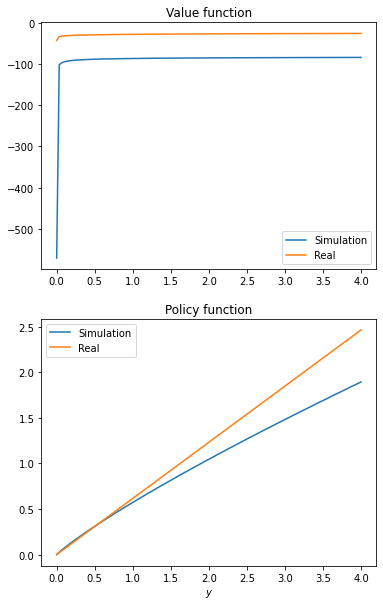

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(6, 10))
for ax, val, title in zip(axes.flatten(), [v, policy], ['Value function', 'Policy function']):
  ax.plot(ogm.y_grids, val, label='Simulation')
  ax.set(title=title)
axes[0].plot(ogm.y_grids, v_star(ogm.y_grids, ogm), label='Real')
axes[1].plot(ogm.y_grids, sigma_star(ogm.y_grids, ogm), label='Real')
axes[0].legend()
axes[1].legend()
axes[1].set(xlabel='$y$');

## Exercise 3

In [7]:
@njit
def Simulation(ogm, policy, y_init=0.1, T=100):
  f, mu, s, y_grids = ogm.f, ogm.mu, ogm.s, ogm.y_grids
  y_sims = np.empty(T+1)
  y_sims[0] = y_init
  shock = np.exp(mu + s*np.random.randn(T))
  sigma = lambda y: interp(y_grids, policy, y)
  for i in prange(T):
    y = y_sims[i]
    y_sims[i+1] = f(y-sigma(y))*shock[i]
  return y_sims

20 iterations take 0.420.

20 iterations take 0.409.

20 iterations take 0.371.

CPU times: user 25.7 s, sys: 72.3 ms, total: 25.8 s
Wall time: 14.1 s


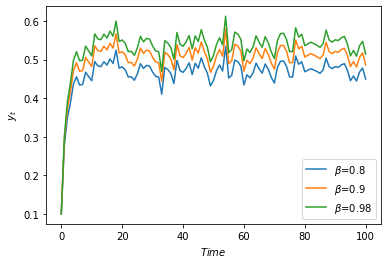

In [8]:
%%time
for beta in [0.8, 0.9, 0.98]:
  ogm = OptimalGrowthModel(gamma=1, beta=beta, s=0.05)
  v = compute_value_function(ogm, max_iter=1000, verbose=False)
  policy = compute_policy(ogm, v)
  sim_y = Simulation(ogm, policy)
  plt.plot(range(len(sim_y)), sim_y, label=fr'$\beta$={beta}')
plt.xlabel('$Time$')
plt.ylabel(r'$y_{t}$')
plt.legend();